# 1. Daten Laden

In [1]:
# Bibliotheken laden
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Dateien von Google Drive bereitstellen
from google.colab import drive
drive.mount('/content/drive')

# Excel auslesen
Datensatz = pd.read_excel('/content/drive/MyDrive/Colab Notebooks/Model Engineering/PSP_Jan_Feb_2019.xlsx',header = 0)
Datensatz = Datensatz.rename(columns = {"Unnamed: 0":"id"})

Mounted at /content/drive


# 2. Modellentwicklung & -bewertung

In [42]:
# Bilbiotheken laden
from sklearn.preprocessing import LabelEncoder
from sklearn import datasets
from sklearn.datasets import make_classification
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from scipy.stats import randint
from sklearn.metrics import  precision_score,roc_curve,auc,accuracy_score, confusion_matrix, precision_score, recall_score, ConfusionMatrixDisplay, f1_score
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objects as go

def Visualisierung_AUC(model,x_test,y_test):
  # Berechnung der Falsch-Positiv-Rate und der Wahr-Positiv-Rate für alle Schwellenwerte der Klassifizierung
  probs = model.predict_proba(x_test)
  preds = probs[:,1]
  fpr, tpr, threshold = roc_curve(y_test, preds)
  roc_auc = auc(fpr, tpr)
  # Visualisierung
  plt.title('Receiver Operating Characteristic')
  plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
  plt.legend(loc = 'lower right')
  plt.plot([0, 1], [0, 1],'r--')
  plt.xlim([0, 1])
  plt.ylim([0, 1])
  plt.ylabel('True Positive Rate')
  plt.xlabel('False Positive Rate')
  plt.show()

def Visualisierung_Class_Errors(model,x_test,y_test):
  #Vorhersage
  y_pred = model.predict(x_test)
  #Zippe Daten in Liste
  list(zip(y_pred,y_test))
  #Enzippe Liste
  unzip_file = [{'y_pred':y_pred,'y_test':y_test}for y_pred,y_test in zip(y_pred,y_test)]
  #Estelle DataFrame
  data = pd.DataFrame(unzip_file)
  #Ermittel Classification Error
  data['class_error'] = abs(data.y_pred-data.y_test)
  data = pd.concat([data,x_test], axis=1, join="inner")
  data['zaehler'] = 1

  # Decode Features
  data['PSP'] = label_encoder_PSP.inverse_transform(data['PSP'])
  data['country'] = label_encoder_country.inverse_transform(data['country'])
  data['card'] = label_encoder_card.inverse_transform(data['card'])
  data['weekday'] = label_encoder_weekday.inverse_transform(data['weekday'])

  # Visualisiere Verteilungen
  fig = make_subplots(rows=1, cols=1, start_cell="top-left")
  fig.add_trace(go.Histogram(x=data[data.class_error == 1].PSP,y=data[data.class_error == 1].zaehler, name='Fehlklassifizierung'),row=1, col=1)
  fig.add_trace(go.Histogram(x=data[data.class_error == 1].card,y=data[data.class_error == 1].zaehler, name='Fehlklassifizierung'),row=1, col=1)
  fig.add_trace(go.Histogram(x=data[data.class_error == 1].country,y=data[data.class_error == 1].zaehler, name='Fehlklassifizierung'),row=1, col=1)
  fig.add_trace(go.Histogram(x=data[data.class_error == 1].weekday,y=data[data.class_error == 1].zaehler, name='Fehlklassifizierung'),row=1, col=1)

  fig.add_trace(go.Histogram(x=data.PSP,y=data.zaehler, name='Anzahl'),row=1, col=1)
  fig.add_trace(go.Histogram(x=data.card,y=data.zaehler, name='Anzahl'),row=1, col=1)
  fig.add_trace(go.Histogram(x=data.country,y=data.zaehler, name='Anzahl'),row=1, col=1)
  fig.add_trace(go.Histogram(x=data.weekday,y=data.zaehler, name='Anzahl'),row=1, col=1)

  #fig = px.histogram(data, x='PSP',color='class_error', title='Verteilung von "PSP"')
  #fig.show()
  #fig = px.histogram(data, x='country',color='class_error', title='Verteilung von "country"')
  #fig.show()
  #fig = px.histogram(data, x='card',color='class_error', title='Verteilung von "card"')
  #fig.show()
  #fig = px.histogram(data, x='weekday',color='class_error', title='Verteilung von "weekday"')
  fig.show()

def Model_Bewertung(model,x_train, y_train,x_test, y_test):
  y_pred_proba = model.predict_proba(x_test)
  print('Bewertungsmetriken')
  print('#'*20)
  print(f"Vorhersage-Genauigkeit auf Basis der Trainingsdaten: {round(model.score(x_train, y_train),2)}")
  print(f"Vorhersage-Genauigkeit auf Basis der Testdaten: {round(model.score(x_test, y_test),2)}")
  print('*'*15)
  precision_train = round(precision_score(y_train,model.predict(x_train),zero_division=1.0,average='weighted'),2)
  precision_test = round(precision_score(y_test,model.predict(x_test),zero_division=1.0,average='weighted'),2)
  print(f"Precision auf Basis der Trainingsdaten: {precision_train}")
  print(f"Precision auf Basis der Testdaten: {precision_test}")
  print('*'*15)
  f1_score_train = round(f1_score(y_train,model.predict(x_train),zero_division=1.0,average='weighted'),2)
  f1_score_test = round(f1_score(y_test,model.predict(x_test),zero_division=1.0,average='weighted'),2)
  print(f"F1-Score auf Basis der Trainingsdaten: {f1_score_train}")
  print(f"F1-Score auf Basis der Testdaten: {f1_score_test}")

# Datenaufbereitung
label_encoder_PSP = LabelEncoder()
label_encoder_country = LabelEncoder()
label_encoder_card = LabelEncoder()
label_encoder_weekday = LabelEncoder()

ML_Daten = Datensatz.filter(['amount','success','PSP','country','card','tmsp','3D_secured'], axis=1)

ML_Daten['country'] = label_encoder_country.fit_transform(ML_Daten['country'])
ML_Daten['PSP'] = label_encoder_PSP.fit_transform(ML_Daten['PSP'])
ML_Daten['card'] = label_encoder_card.fit_transform(ML_Daten['card'])

# Datumswerte in Tag/ Wochentag/ Stunde aufteilen
ML_Daten['weekday'] = ML_Daten['tmsp'].dt.day_name()
ML_Daten['weekday'] = label_encoder_weekday.fit_transform(ML_Daten['weekday'])
ML_Daten['day'] = ML_Daten['tmsp'].dt.strftime('%d').astype(int)
ML_Daten['hour'] = ML_Daten['tmsp'].dt.strftime('%H').astype(int)

# Separation in X Merkmale and Zielvariable Y
Y = ML_Daten['success']
X = ML_Daten.filter(['amount','PSP','3D_secured','card','country','weekday','day','hour'], axis=1)

# Aufteilung in Trainings- und Validierungsdatensatz
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.2)

## 2.1 RandomForest

Bewertungsmetriken
####################
Vorhersage-Genauigkeit auf Basis der Trainingsdaten: 0.8
Vorhersage-Genauigkeit auf Basis der Testdaten: 0.8
***************
Precision auf Basis der Trainingsdaten: 0.84
Precision auf Basis der Testdaten: 0.84
***************
F1-Score auf Basis der Trainingsdaten: 0.71
F1-Score auf Basis der Testdaten: 0.7


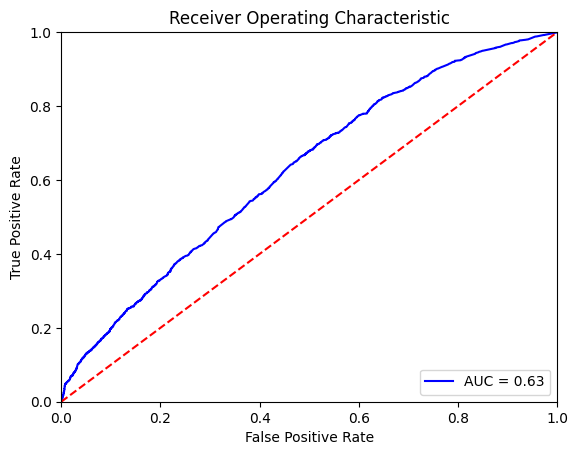

In [43]:
from sklearn.ensemble import RandomForestClassifier

rfc = RandomForestClassifier(max_depth = 2)
rfc.fit(x_train, y_train)

Model_Bewertung(rfc,x_train, y_train,x_test, y_test)
Visualisierung_AUC(rfc,x_test,y_test)
Visualisierung_Class_Errors(rfc,x_test,y_test)

## 2.2 Logistische Regression

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



Bewertungsmetriken
####################
Vorhersage-Genauigkeit auf Basis der Trainingsdaten: 0.8
Vorhersage-Genauigkeit auf Basis der Testdaten: 0.8
***************
Precision auf Basis der Trainingsdaten: 0.84
Precision auf Basis der Testdaten: 0.84
***************
F1-Score auf Basis der Trainingsdaten: 0.71
F1-Score auf Basis der Testdaten: 0.7


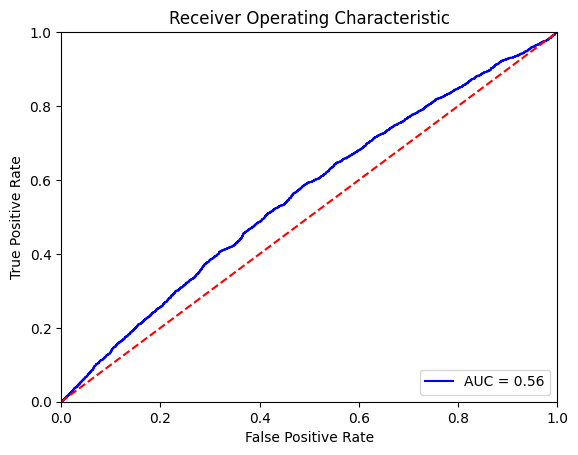

In [44]:
from sklearn.linear_model import LogisticRegression
from sklearn import preprocessing

x_train_scaled = preprocessing.StandardScaler().fit(x_train)

lg = LogisticRegression(max_iter=10)
lg.fit(x_train, y_train)

Model_Bewertung(lg,x_train, y_train,x_test, y_test)
Visualisierung_AUC(lg,x_test,y_test)
Visualisierung_Class_Errors(lg,x_test,y_test)

## 2.3 KNN

Bewertungsmetriken
####################
Vorhersage-Genauigkeit auf Basis der Trainingsdaten: 0.82
Vorhersage-Genauigkeit auf Basis der Testdaten: 0.77
***************
Precision auf Basis der Trainingsdaten: 0.79
Precision auf Basis der Testdaten: 0.69
***************
F1-Score auf Basis der Trainingsdaten: 0.77
F1-Score auf Basis der Testdaten: 0.71


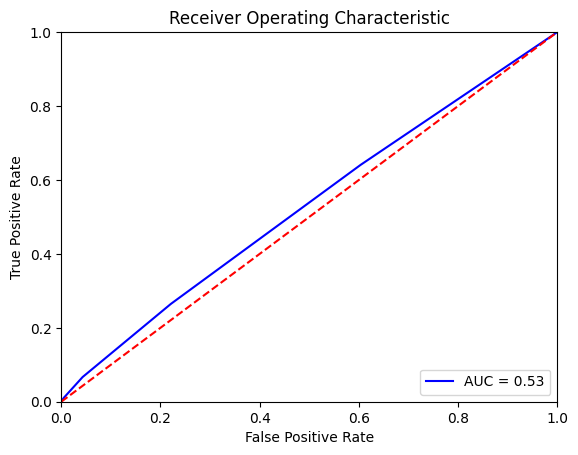

In [45]:
from sklearn.neighbors import KNeighborsClassifier

KNN = KNeighborsClassifier()
KNN.fit(x_train, y_train)

y_pred_proba = KNN.predict_proba(x_test)

Model_Bewertung(KNN,x_train, y_train,x_test, y_test)
Visualisierung_AUC(KNN,x_test,y_test)
Visualisierung_Class_Errors(KNN,x_test,y_test)

## 2.4 Support Vektor Machine